In [ ]:
# %pip install torch torchvision matplotlib

### Imports

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from copy import deepcopy
import matplotlib.pyplot as plt

### Hyperparams

In [51]:
M = 5      # Number of clients
A = 1      # Local epochs
G = 20     # Global rounds
lr = 0.01  # Learning rate
bs = 32    # Batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Data

In [52]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='.', train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)


### Model

In [53]:
def create_model():
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 32),
        nn.ReLU(),
        nn.Linear(32, 10)
    )

### IID partition

In [54]:
def get_client_loaders(dataset, M, bs):
    indices = torch.randperm(len(dataset))
    split = len(dataset) // M
    loaders = []
    for i in range(M):
        part = indices[i*split:(i+1)*split]
        loaders.append(DataLoader(Subset(dataset, part), batch_size=bs, shuffle=True))
    return loaders

client_loaders = get_client_loaders(train_data, M, bs)

#### Local trainning (FL)

In [55]:
def local_update(model, loader, epochs, lr):
    model = deepcopy(model).to(device).train()
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
    return model.state_dict()

### Weight Aggregation

In [56]:
def average_weights(w_list):
    avg = deepcopy(w_list[0])
    for key in avg:
        for w in w_list[1:]:
            avg[key] += w[key]
        avg[key] = avg[key] / len(w_list)
    return avg

### Evaluation

In [57]:
def evaluate(model, loader, compute_loss=False):
    model = deepcopy(model).to(device).eval()
    correct, total, total_loss = 0, 0, 0.0
    loss_fn = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            if compute_loss:
                total_loss += loss_fn(logits, y).item() * y.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    acc = correct / total
    if compute_loss:
        return total_loss / total, acc
    return acc

### Centralized Training

In [58]:
def train_centralized(data, test_loader):
    model = create_model().to(device)
    loader = DataLoader(data, batch_size=bs, shuffle=True)
    opt = torch.optim.SGD(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    hist = {'train_loss': [], 'train_acc': [], 'test_acc': []}

    for epoch in range(1, G+1):
        model.train()
        total_loss, correct, total = 0.0, 0, 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            opt.step()
            total_loss += loss.item() * y.size(0)
            correct += (logits.argmax(1) == y).sum().item()
            total += y.size(0)
        acc = correct / total
        test_acc = evaluate(model, test_loader)
        hist['train_loss'].append(total_loss / total)
        hist['train_acc'].append(acc)
        hist['test_acc'].append(test_acc)
        print(f"[Centralized {epoch}] Loss={total_loss/total:.4f} Acc={acc:.2%} Test={test_acc:.2%}")
    return hist

###  Federated Training

In [59]:
def train_federated(client_loaders, test_loader):
    global_model = create_model().to(device)
    
    hist = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': [],
        'comm_cost_MB': []
    }
    # Precompute model size in MB
    model_size_mb = sum(p.numel() for p in global_model.parameters()) * 4 / 1e6

    for rnd in range(1, G+1):
        # Local updates
        w_locals = [local_update(global_model, loader, A, lr)
                    for loader in client_loaders]
        # Aggregate
        global_model.load_state_dict(average_weights(w_locals))

        # Metrics
        tloss, tacc = evaluate(global_model,
                               DataLoader(train_data, batch_size=bs),
                               compute_loss=True)
        test_acc = evaluate(global_model, test_loader)

        # Append to history
        hist['train_loss'].append(tloss)
        hist['train_acc'].append(tacc)
        hist['test_acc'].append(test_acc)
        # Communication cost: each client uploads+downloads model once per round
        hist['comm_cost_MB'].append(model_size_mb * 2 * len(client_loaders))

        print(f"[Federated {rnd}] "
              f"Loss={tloss:.4f} Acc={tacc:.2%} Test={test_acc:.2%} "
              f"Comm={hist['comm_cost_MB'][-1]:.2f} MB")

    return hist


### Code Runs

In [60]:
def run_all():
    central_hist = train_centralized(train_data, test_loader)
    fed_hist = train_federated(client_loaders, test_loader)
    rounds = range(1, G+1)

    plt.figure()
    plt.plot(rounds, central_hist['train_loss'], label='Centralized Train Loss')
    plt.plot(rounds, fed_hist['train_loss'], label='Federated Train Loss')
    plt.xlabel("Epoch / Round")
    plt.ylabel("Training Loss")
    plt.legend()

    plt.figure()
    plt.plot(rounds, central_hist['train_acc'], label='Centralized Train Acc')
    plt.plot(rounds, fed_hist['train_acc'], label='Federated Train Acc')
    plt.xlabel("Epoch / Round")
    plt.ylabel("Training Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(rounds, central_hist['test_acc'], label='Centralized Test Acc')
    plt.plot(rounds, fed_hist['test_acc'], label='Federated Test Acc')
    plt.xlabel("Epoch / Round")
    plt.ylabel("Test Accuracy")
    plt.legend()

    plt.show()

### Plot

In [61]:
def plot_losses(cent, fed):
    plt.figure()
    plt.plot(range(1, G+1), cent['train_loss'], label='Cent. Train Loss')
    plt.plot(range(1, G+1), fed ['train_loss'], label='Fed. Train Loss')
    plt.xlabel('Epoch / Round'); plt.ylabel('Loss'); plt.legend()

def plot_accuracies(cent, fed):
    plt.figure()
    plt.plot(range(1, G+1), cent['test_acc'], label='Cent. Test Acc')
    plt.plot(range(1, G+1), fed ['test_acc'], label='Fed. Test Acc')
    plt.xlabel('Epoch / Round'); plt.ylabel('Accuracy'); plt.legend()

def plot_train_vs_val(cent, fed):
    plt.figure()
    plt.plot(range(1, G+1), cent['train_acc'], label='Cent. Train Acc')
    plt.plot(range(1, G+1), cent['test_acc'],  label='Cent. Val Acc', linestyle='--')
    plt.plot(range(1, G+1), fed ['train_acc'], label='Fed. Train Acc')
    plt.plot(range(1, G+1), fed ['test_acc'],  label='Fed. Val Acc', linestyle='--')
    plt.xlabel('Epoch / Round'); plt.ylabel('Accuracy'); plt.legend()

def plot_comm_cost(fed):
    plt.figure()
    plt.plot(range(1, G+1), fed['comm_cost_MB'], marker='o')
    plt.xlabel('Federated Round'); plt.ylabel('Comm. Cost (MB per round)')
    plt.title('Communication Cost Over Rounds')

def show_all_plots(cent_hist, fed_hist):
    plot_losses(cent_hist, fed_hist)
    plot_accuracies(cent_hist, fed_hist)
    plot_train_vs_val(cent_hist, fed_hist)

    # Only plot communication cost if it exists
    if 'comm_cost_MB' in fed_hist:
        plot_comm_cost(fed_hist)
    else:
        print("Warning: 'comm_cost_MB' not found in fed_hist, skipping comm-cost plot.")

    plt.show()

def run_experiment():
    cent_hist = train_centralized(train_data, test_loader)
    fed_hist  = train_federated(client_loaders, test_loader)
    show_all_plots(cent_hist, fed_hist)

### Boom

[Centralized 1] Loss=0.9101 Acc=76.66% Test=88.82%
[Centralized 2] Loss=0.3834 Acc=89.41% Test=90.73%
[Centralized 3] Loss=0.3290 Acc=90.68% Test=91.64%
[Centralized 4] Loss=0.3013 Acc=91.44% Test=92.16%
[Centralized 5] Loss=0.2810 Acc=92.01% Test=92.50%
[Centralized 6] Loss=0.2642 Acc=92.52% Test=93.06%
[Centralized 7] Loss=0.2496 Acc=92.96% Test=93.32%
[Centralized 8] Loss=0.2366 Acc=93.30% Test=93.69%
[Centralized 9] Loss=0.2249 Acc=93.70% Test=93.82%
[Centralized 10] Loss=0.2147 Acc=93.92% Test=94.02%
[Centralized 11] Loss=0.2055 Acc=94.21% Test=94.16%
[Centralized 12] Loss=0.1975 Acc=94.42% Test=94.50%
[Centralized 13] Loss=0.1901 Acc=94.64% Test=94.60%
[Centralized 14] Loss=0.1836 Acc=94.83% Test=94.85%
[Centralized 15] Loss=0.1779 Acc=94.95% Test=94.94%
[Centralized 16] Loss=0.1722 Acc=95.08% Test=94.95%
[Centralized 17] Loss=0.1672 Acc=95.25% Test=94.94%
[Centralized 18] Loss=0.1626 Acc=95.39% Test=95.21%
[Centralized 19] Loss=0.1582 Acc=95.54% Test=95.35%
[Centralized 20] Loss

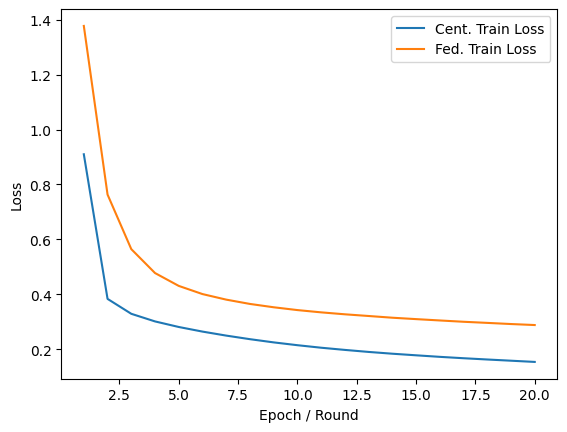

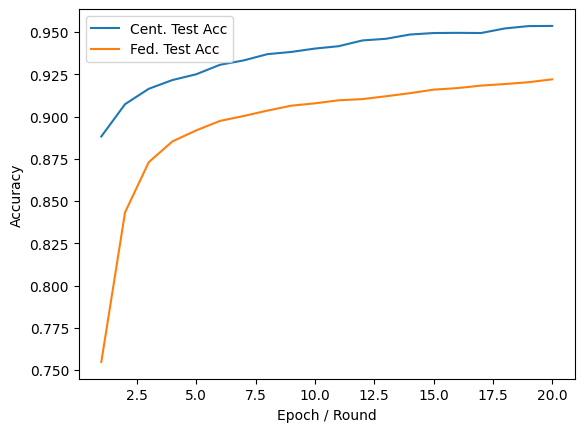

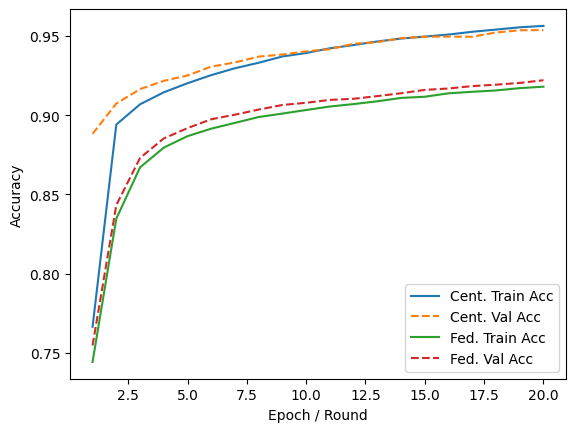

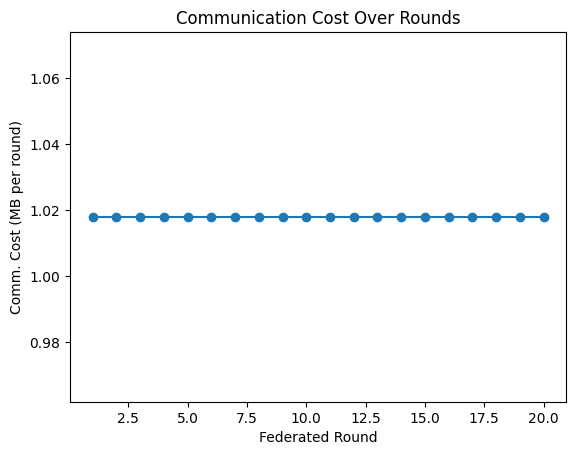

In [62]:
if __name__ == "__main__":
    run_experiment()